# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import data_transforations as data_tr


## Models

In [2]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold



## Scoring

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

### Recall

In [4]:
#cross_val_score(clf, X, y, cv=5, scoring='recall')
#cv= the number of folds in cross validation

### Precision

In [5]:
#cross_val_score(clf, X, y, cv=5, scoring='precision')

### F-beta 

F1 score but you can choose the weighting between recall and precision, where f1 is 50:50

In [6]:
#fbeta_scorer = make_scorer(fbeta_score, beta=2) 
#in model fitting: scoring=fbeta_scorer
##cross_val_score(clf, X, y, cv=5, scoring=fbeta_scorer)
# beta is the ratio of recall:precision, so beta=2 means rcall2:1precision and beta =0.5 means recall1:2precision

# Modeling **with** economic variables

## Loading data

In [51]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
at_inception=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
at_inception=at_inception.drop(columns=['Unnamed: 0'])
at_inception.head()

,policy_name,education,gender,smoker_status,sold_socio_economic_class,underwriting_outcome,optionality,eml,pml,securitygroup_id,...,1month_lapse,3month_lapse,6month_lapse,ann_lapse,age_band,income_band,last_benefit_amount_band,cover_amount_full_band,total_funeral_premium_band,original_premium_band
0,MWL008050072,Matric,Male,S,1.0,NaN,0.0,0.00,0.0,MWL,...,0,0,0,0.0,> 45.50,> 30050.00,526225.72 - 1050857.19,525032.38 - 1016188.00,< 12.53,> 519.78
1,ML24-0199554,Matric + 3 year Diploma,Female,N,2.0,Accepted with Loadings,1.0,-0.05,0.0,MWL,...,0,0,0,0.0,< 29.50,13842.50 - 29979.50,> 1485646.31,> 1016188.00,< 12.53,236.86 - 298.74
2,ML24-0254853,Matric + 3 year Diploma,Female,E,1.0,Accepted with Loadings,1.0,0.60,0.0,MWL,...,0,0,0,NaN,> 45.50,> 30050.00,< 201014.05,< 105015.62,< 12.53,236.86 - 298.74
3,ML23-0067459,Matric + 3 year Diploma,Male,S,1.0,Accepted with Loadings,1.0,1.05,0.0,MWL,...,0,0,0,0.0,38.50 - 45.50,> 30050.00,< 201014.05,< 105015.62,< 12.53,< 236.86
4,MWL007912004,4 year Degree,Female,N,1.0,NaN,0.0,0.00,0.0,MWL,...,0,0,0,0.0,33.50 - 38.50,> 30050.00,1050857.19 - 1485646.31,213181.66 - 525032.38,> 127.59,352.18 - 414.27


## Hot-one encode all categorical data and dropping NaN values

In [53]:
# impute missing values

at_inception['optionality'].fillna(0,inplace=True)

C:\Users\E1005279\AppData\Local\Temp\ipykernel_23264\2616564041.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  at_inception['optionality'].fillna(0,inplace=True)


In [54]:
at_inception=pd.get_dummies(at_inception,columns=['underwriting_outcome'],dummy_na=True, dtype=int)
at_inception=pd.get_dummies(at_inception,columns=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'securitygroup_id', 'age_band', 'income_band',
       'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'], dtype=int)
#dummy_na=True encodes NaN values into column,
#    only underwriting_outcome has significant number of missing values, which do indicate that underwritng was not required thus useful to know

## Lasso for feature importance

In [55]:
cols=set(at_inception.columns)
column_excl = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name']
features=list(cols.difference(column_excl))

In [56]:
X_lapse = at_inception[features].copy()
Y_lapse = at_inception['lapse_flag'].astype(int).copy()


In [57]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_lapse, Y_lapse, test_size=0.20, random_state=42, stratify=Y_lapse)

In [66]:

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 1, 0.1)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso(max_iter=5000)

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))


: 

: 

In [62]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e+03, tolerance: 9.295e-01
  model = cd_fast.enet_coordinate_descent(


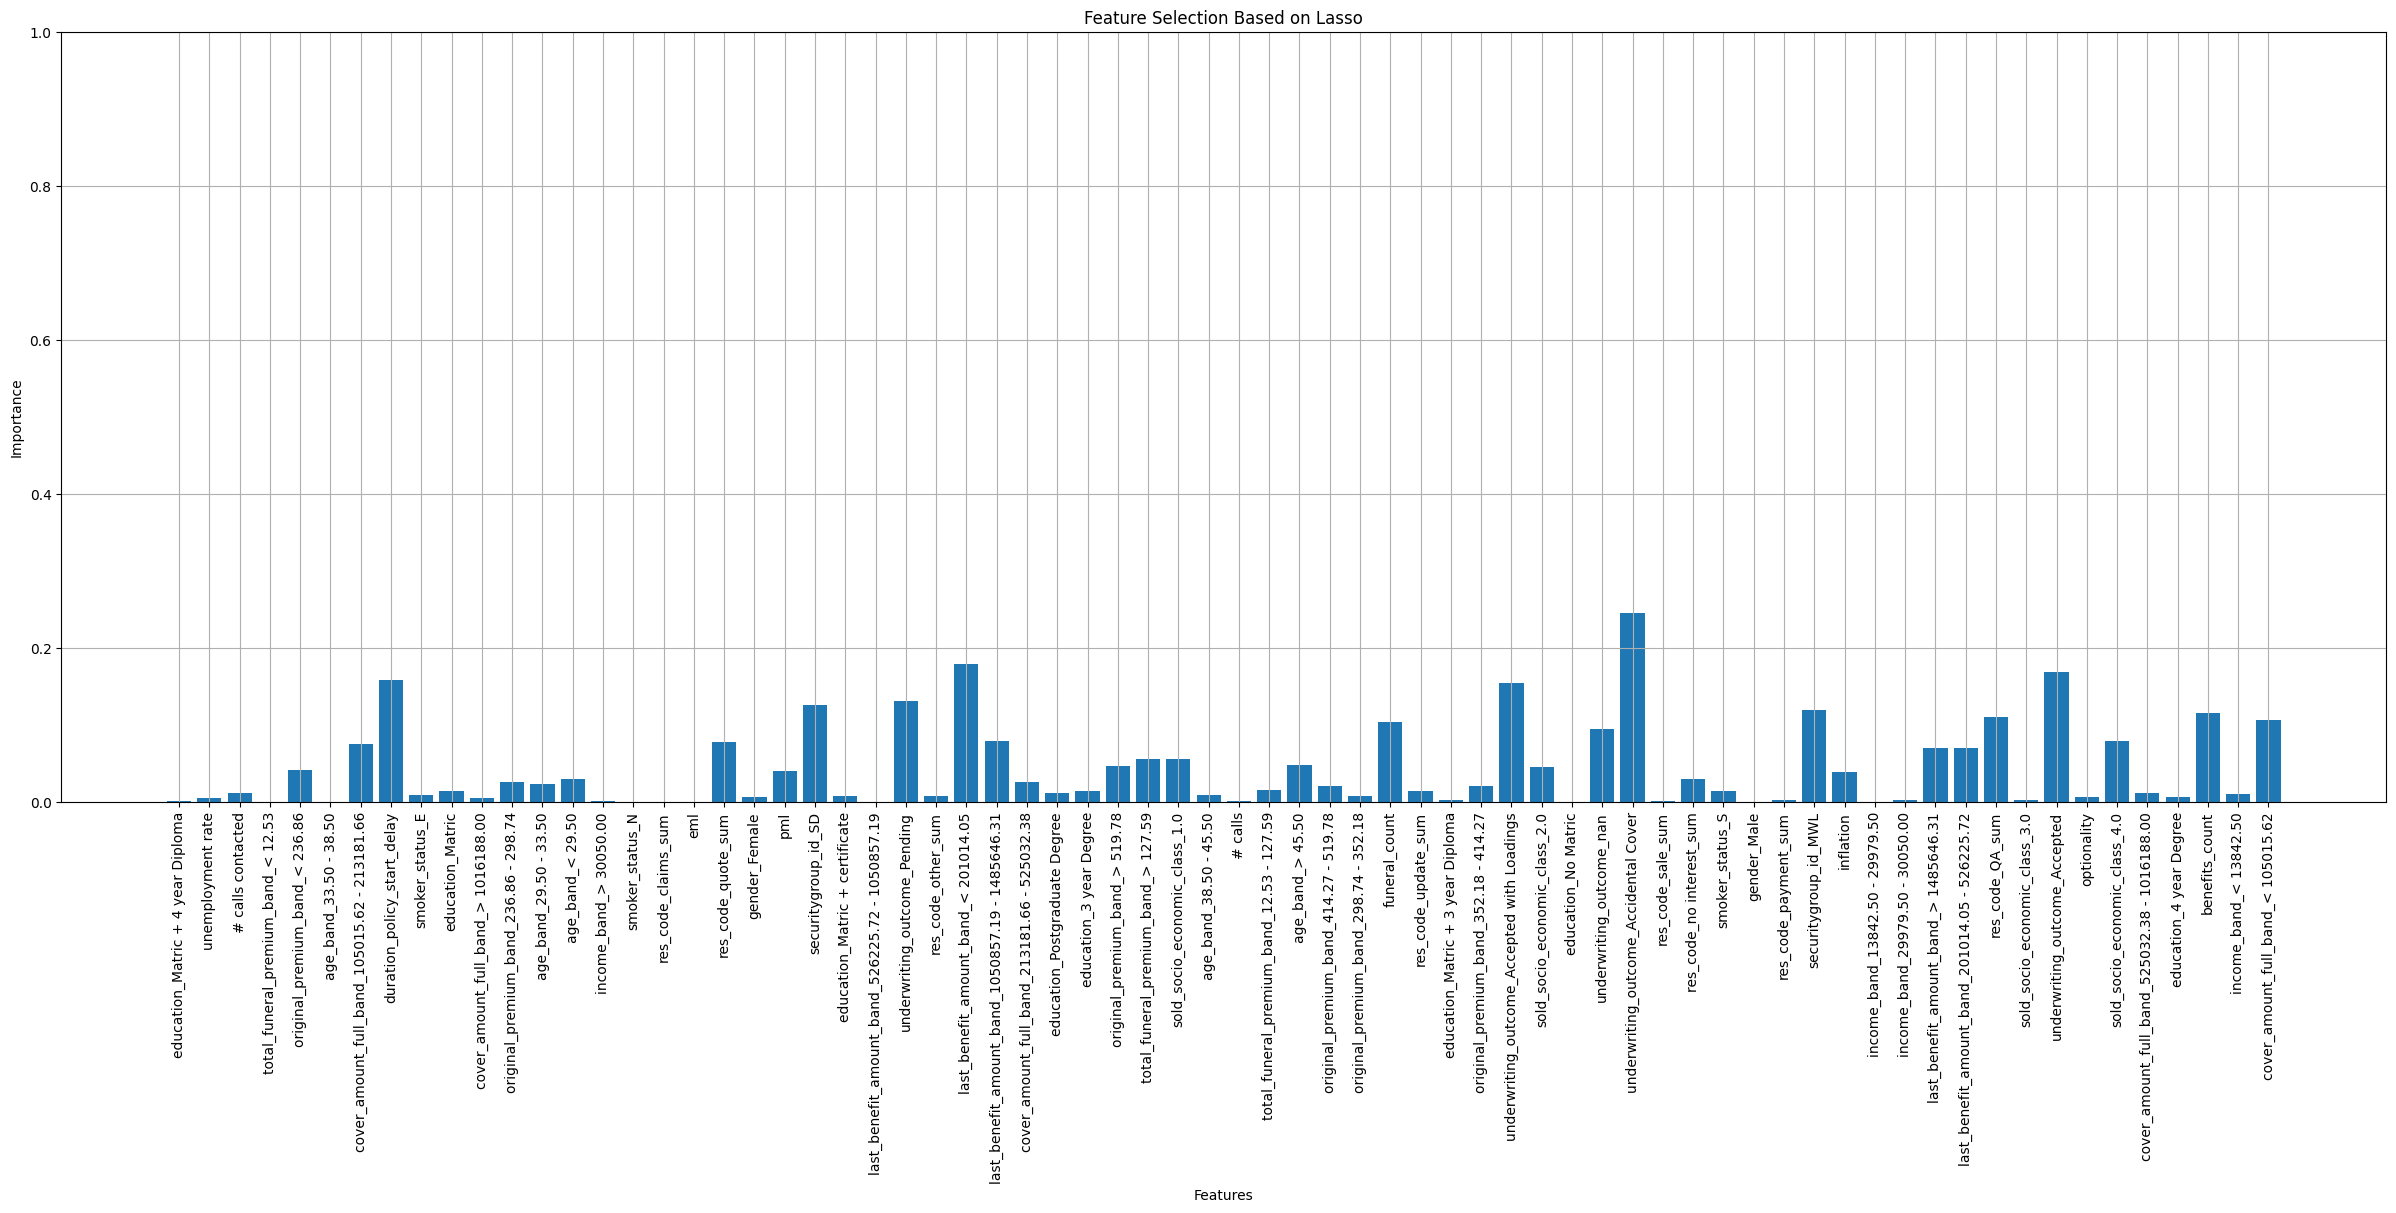

In [65]:

# plotting the Column Names and Importance of Columns. 
plt.figure(figsize=(30, 10))
plt.bar(X_train.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 1)

plt.show()

# Modeling **without** economic variables

In [ ]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
at_inception=pd.DataFrame(pd.read_csv(path+"inception_data_v4.csv"))